# IVOL Puzzle - Idiosyncratic Volatility

This project aims to study the relationship between idiosyncratic volatility and expected return on equities. It attempts to recreate the study done by Stambaugh et al in 2015, with updated dataset up to 2024.

Idiosyncratic volatility is defined as the volatility of residuals when historical returns are regressed against Fama-French 3 factors. In line with Stambaugh's approach, we calculate IVOL over a historical period of one month. This yields a time series of IVOL values for each stock in our universe. 

```
for each date in date range:
    for each stock in universe:
        retrieve past month of excess stock returns
        regress excess returns against FF 3 factors
        calculate standard deviation of residuals
```

At the same time, we use a composite, cross sectional measure for mispricing based on 10 return anomalies (the financial distress score is not easily retrievable). Each return anomaly is a time series object for each stock in our universe. To arrive at a composite measure for each time stamp, for each return anomaly, we rank each stock by the return anomaly. This yields 10 different rankings for each stock on any given day. We take the arithmetic mean of the 10 rankings to be the composite cross sectional measure of mispricing. 

```
for each date_i in date range:
    for each return_anomaly_j in return anomalies:
        rank all stocks for which return_anomaly_j can be calculated on date_i
    for each stock_k in universe:
        calculate arithmetic mean of rank_{j, k} for all j
```

With IVOL and mispricing measure, for each date, we sort stocks on IVOL and mispricing, grouping into 5 groups along each dimension. This forms 25 different baskets of stocks. We form each into a value-weighted portfolio. We then calculate the return on this portfolio for the next month, and regress against fama-french 3 factors to find the return that survive factor adjustment. 

```
for each date in date range:
    sort stocks on IVOL, assign a label 1-5 for each stock
    sort stocks on mispricing, assign a label 1-5 for each stock
    form 25 value-weighted portfolios e.g. most underpriced and lowest IVOL stock ends up in basket (1, 1)
for each portfolio in the 25 value-weighted portfolios:
    calculate a series of monthly returns
    regress against FF 3 factors (monthly factors)
    calculate abnormal return on each portfolio
```




In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from datetime import datetime
import numpy as np
import seaborn as sns
import wrds
import statsmodels.api as sm
from scipy.stats import percentileofscore

plt.style.use('seaborn-v0_8-notebook')
eps = 1e-8
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = [10, 6]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.autolayout'] = True

conn = wrds.Connection()
start = "1965-01-01"
end = "2025-01-01"

Loading library list...
Done


## Data Access - Stocks universe

In line with Stambaugh's methodology, we use all NYSE/AMex/NASDAQ stocks with share prices greater than five dollars. 

Stambaugh's research covered data from 1965 to 2011. We retrieve data from 1965 to 2024.

Our stock universe is the series of tickers for each month where the stock price is above five dollars. 

In [2]:
start = '1965-01-01'
end = '2025-01-01'

In [4]:
# we begin by extracting all tickers in our universe
tickers = conn.raw_sql(
    f"""
    SELECT permno, ticker, namedt
    FROM crsp.msenames
    WHERE namedt BETWEEN '{start}' AND '{end}'
    AND exchcd in (1, 2, 3)
    """
)
tickers

,permno
0,83264
1,63618
2,10896
3,69906
4,79030
...,...
33695,81454
33696,79163
33697,86036
33698,92970


We want to check for functional dependency in this dataframe. We are interested in knowing if namedt and permno uniquely identifies a ticker. 

In [28]:
violations = (
    tickers.groupby(['permno', 'namedt'])['ticker']
    .nunique()
    .reset_index()
    .query('ticker > 1')
)

# Output result
if violations.empty:
    print("(permno, namedt) uniquely identifies ticker (i.e., functional dependency holds).")
else:
    print("These (permno, namedt) pairs map to multiple tickers:")
    display(violations)

(permno, namedt) uniquely identifies ticker (i.e., functional dependency holds).


From documentation, we understand that PERMNO is a unique five-digit permanent identifier assigned by CRSP to each security in the file. Unlike CUSIP, TICKER, and COMNAM, the PERMNO neither changes during an issue's trading history, nor is reassigned after an issue ceases trading. The user may track a security through its entire trading history in CRSP's files with one PERMNO, regardless of name changes or capital structure changes. A security that is included on both CRSP's Nasdaq and NYSE/AMEX files will have the same CRSP permanent number in both files.

In [5]:
tickers = conn.raw_sql(
    f"""
    SELECT DISTINCT permno 
    FROM crsp.msenames
    WHERE namedt BETWEEN '{start}' AND '{end}'
    AND exchcd in (1, 2, 3)
    """
)
tickers

,permno
0,83264
1,63618
2,10896
3,69906
4,79030
...,...
33695,81454
33696,79163
33697,86036
33698,92970


We generate a list of month-end dates between the start and end of our dataset. 

In [7]:
dates = pd.date_range(
    start=start,
    end=end,
    freq='ME'
)

dates

DatetimeIndex(['1965-01-31', '1965-02-28', '1965-03-31', '1965-04-30',
               '1965-05-31', '1965-06-30', '1965-07-31', '1965-08-31',
               '1965-09-30', '1965-10-31',
               ...
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', length=720, freq='ME')

## Data Access - IVOL calculation

In [127]:
month_end_dates = pd.date_range(
    start=start,
    end=end,
    freq='ME'
)

factors = conn.raw_sql(
    f"""
    SELECT date, mktrf, smb, hml, rf
    FROM ff.factors_daily
    WHERE date BETWEEN '{start}' AND '{end}'
    """,
    date_cols = ['date']
).set_index('date')

factors = (
    factors.replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(float)
)

factors

,mktrf,smb,hml,rf
date,,,,
1965-01-04,-0.0045,0.0070,-0.0008,0.00014
1965-01-05,0.0049,0.0038,-0.0009,0.00014
1965-01-06,0.0034,0.0018,0.0042,0.00014
1965-01-07,0.0040,0.0008,0.0019,0.00014
1965-01-08,0.0017,0.0017,-0.0020,0.00014
...,...,...,...,...
2024-12-24,0.0111,-0.0009,-0.0005,0.00017
2024-12-26,0.0002,0.0104,-0.0019,0.00017
2024-12-27,-0.0117,-0.0066,0.0056,0.00017


In [23]:
permno = tickers['permno'][5]
rets = conn.raw_sql(
    f"""
    SELECT permno, date, ret 
    FROM crsp.dsf
    WHERE date BETWEEN '{start}' AND '{end}'
    AND permno = {permno}
    """
)

rets

,permno,date,ret
0,33770,1996-10-07,<NA>
1,33770,1996-10-08,<NA>
2,33770,1996-10-09,<NA>
3,33770,1996-10-10,<NA>
4,33770,1996-10-11,<NA>
...,...,...,...
11612,33770,2024-12-24,0.031209
11613,33770,2024-12-26,0.039923
11614,33770,2024-12-27,-0.044582
11615,33770,2024-12-30,0.009073


In [10]:
ivol_df = pd.DataFrame(
    index = month_end_dates,
    columns = tickers['permno'].unique()
)
ivol_df

,83264,63618,10896,69906,79030,11233,44127,86580,91786,88837,...,56120,31713,85792,83586,89403,81454,79163,86036,92970,19812
1965-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
for i, col in enumerate(ivol_df.columns[:100]):
    print(f"Processing column {i} out of {len(ivol_df.columns)}")
    permno = col
    ret_df = (
        conn.raw_sql(
        f"""
        SELECT date, ret
        FROM crsp.dsf
        WHERE date BETWEEN '{start}' AND '{end}'
        AND permno = {permno}
        """,
        date_cols = ['date'])
        .set_index('date')
        .merge(
            factors,
            left_index=True,
            right_index=True,
            how='left'
        )
    )
    ret_df['ex_ret'] = ret_df['ret'] - ret_df['rf']

    for idx in ivol_df.index:
        time_range_mask = (
            (ret_df.index >= idx - pd.DateOffset(months = 1)) * (ret_df.index <= idx)
        )
        X = np.asarray(
            ret_df[['mktrf', 'smb', 'hml']][time_range_mask]
        )
        y = np.asarray(
            ret_df[['ex_ret']][time_range_mask]
        )

        if X.shape[0] != 0:
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            ivol = np.std(
                model.resid
            )
            ivol_df.loc[idx, col] = ivol

Processing column 0 out of 33700
Processing column 1 out of 33700
Processing column 2 out of 33700
Processing column 3 out of 33700
Processing column 4 out of 33700
Processing column 5 out of 33700
Processing column 6 out of 33700
Processing column 7 out of 33700
Processing column 8 out of 33700
Processing column 9 out of 33700
Processing column 10 out of 33700
Processing column 11 out of 33700
Processing column 12 out of 33700
Processing column 13 out of 33700
Processing column 14 out of 33700
Processing column 15 out of 33700
Processing column 16 out of 33700
Processing column 17 out of 33700
Processing column 18 out of 33700
Processing column 19 out of 33700
Processing column 20 out of 33700
Processing column 21 out of 33700
Processing column 22 out of 33700
Processing column 23 out of 33700
Processing column 24 out of 33700
Processing column 25 out of 33700
Processing column 26 out of 33700
Processing column 27 out of 33700
Processing column 28 out of 33700
Processing column 29 out

In [62]:
# Split ivol_df into 4 parts by columns
num_splits = 4
split_size = len(ivol_df.columns) // num_splits
splits = [ivol_df.iloc[:, i * split_size:(i + 1) * split_size] for i in range(num_splits)]

# Save each split to a CSV file
for i, split in enumerate(splits):
    split.to_csv(f'ivol_part_{i + 1}.csv')

In [63]:
ivol_df = pd.read_csv(
    './ivol_part_4.csv',
    index_col=0
)

ivol_df.index = pd.to_datetime(ivol_df.index)

ivol_df

,89728,84750,25212,85272,91175,23387,93198,71458,19255,66895,...,56120,31713,85792,83586,89403,81454,79163,86036,92970,19812
1965-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
for i, col in enumerate(ivol_df.columns):
    print(f"Processing column {i} out of {len(ivol_df.columns)}")
    permno = col
    ret_df = (
        conn.raw_sql(
        f"""
        SELECT date, ret
        FROM crsp.dsf
        WHERE date BETWEEN '{start}' AND '{end}'
        AND permno = {permno}
        """,
        date_cols = ['date'])
        .set_index('date')
        .merge(
            factors,
            left_index=True,
            right_index=True,
            how='left'
        )
    )
    ret_df['ex_ret'] = ret_df['ret'] - ret_df['rf']

    for idx in ivol_df.index:
        time_range_mask = (
            (ret_df.index >= idx - pd.DateOffset(months = 1)) * (ret_df.index <= idx)
        )
        X = np.asarray(
            ret_df[['mktrf', 'smb', 'hml']][time_range_mask]
        )
        y = np.asarray(
            ret_df[['ex_ret']][time_range_mask]
        )

        if X.shape[0] != 0:
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            ivol = np.std(
                model.resid
            )
            ivol_df.loc[idx, col] = ivol

Processing column 0 out of 8425
Processing column 1 out of 8425
Processing column 2 out of 8425
Processing column 3 out of 8425
Processing column 4 out of 8425
Processing column 5 out of 8425
Processing column 6 out of 8425
Processing column 7 out of 8425
Processing column 8 out of 8425
Processing column 9 out of 8425
Processing column 10 out of 8425
Processing column 11 out of 8425
Processing column 12 out of 8425
Processing column 13 out of 8425
Processing column 14 out of 8425
Processing column 15 out of 8425
Processing column 16 out of 8425
Processing column 17 out of 8425
Processing column 18 out of 8425
Processing column 19 out of 8425
Processing column 20 out of 8425
Processing column 21 out of 8425
Processing column 22 out of 8425
Processing column 23 out of 8425
Processing column 24 out of 8425
Processing column 25 out of 8425
Processing column 26 out of 8425
Processing column 27 out of 8425
Processing column 28 out of 8425
Processing column 29 out of 8425
Processing column 30

In [65]:
ivol_df.to_csv('./ivol_part_4.csv')

In [126]:
ivol_df = pd.read_csv('./full_ivol_df.csv', index_col=0)
ivol_df.index = pd.to_datetime(ivol_df.index)
ivol_df

,83264,63618,10896,69906,79030,11233,44127,86580,91786,88837,...,56120,31713,85792,83586,89403,81454,79163,86036,92970,19812
1965-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.011945,NaN,NaN,NaN,NaN,NaN,NaN,0.025849,0.009253,0.013778,...,NaN,NaN,0.015452,NaN,0.018388,NaN,NaN,NaN,NaN,0.042034
2024-09-30,0.010587,NaN,NaN,NaN,NaN,NaN,NaN,0.011175,0.011429,0.010877,...,NaN,NaN,0.012494,NaN,0.010137,NaN,NaN,NaN,NaN,0.162169
2024-10-31,0.007728,NaN,NaN,NaN,NaN,NaN,NaN,0.016819,0.010310,0.047612,...,NaN,NaN,0.008540,NaN,0.009744,NaN,NaN,NaN,NaN,0.045123
2024-11-30,0.008987,NaN,NaN,NaN,NaN,NaN,NaN,0.017378,0.012528,0.048934,...,NaN,NaN,0.010319,NaN,0.024362,NaN,NaN,NaN,NaN,0.108532


In [137]:
data_coverage = {}
for col in ivol_df.columns:
    data_coverage[col] = (
            (~ivol_df[col].isna()).sum()/ivol_df.shape[0]
    )
    print(f"Permno {col} coverage: {(~ivol_df[col].isna()).sum()/ivol_df.shape[0]}")

Permno 83264 coverage: 0.4791666666666667
Permno 63618 coverage: 0.15
Permno 10896 coverage: 0.059722222222222225
Permno 69906 coverage: 0.36666666666666664
Permno 79030 coverage: 0.10277777777777777
Permno 11233 coverage: 0.1375
Permno 44127 coverage: 0.08472222222222223
Permno 86580 coverage: 0.43194444444444446
Permno 91786 coverage: 0.2972222222222222
Permno 88837 coverage: 0.4
Permno 88451 coverage: 0.30694444444444446
Permno 76791 coverage: 0.20416666666666666
Permno 89714 coverage: 0.019444444444444445
Permno 83471 coverage: 0.06805555555555555
Permno 35634 coverage: 0.10416666666666667
Permno 40694 coverage: 0.8263888888888888
Permno 20549 coverage: 0.030555555555555555
Permno 84198 coverage: 0.07777777777777778
Permno 25886 coverage: 0.0
Permno 86008 coverage: 0.29444444444444445
Permno 83307 coverage: 0.32916666666666666
Permno 76021 coverage: 0.058333333333333334
Permno 23851 coverage: 0.5916666666666667
Permno 92621 coverage: 0.2777777777777778
Permno 86727 coverage: 0.0944

Text(0, 0.5, 'Data Coverage')

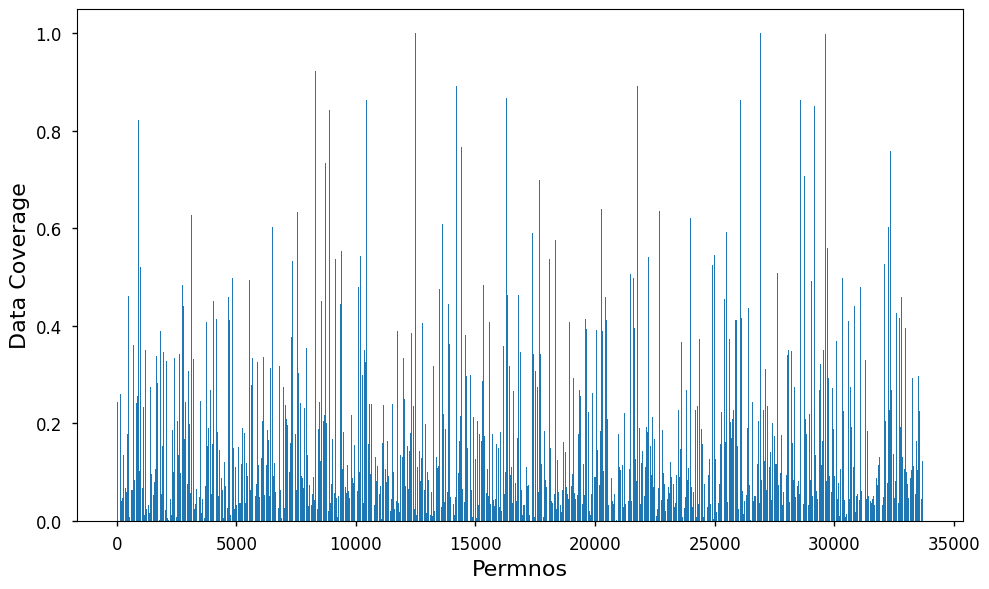

In [139]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.bar(
    np.arange(len(data_coverage.keys())),
    data_coverage.values()
)

ax.set_xlabel("Permnos")
ax.set_ylabel("Data Coverage")


In [140]:
ivol_df.to_csv('./full_ivol_df.csv')

## IVOL EDA

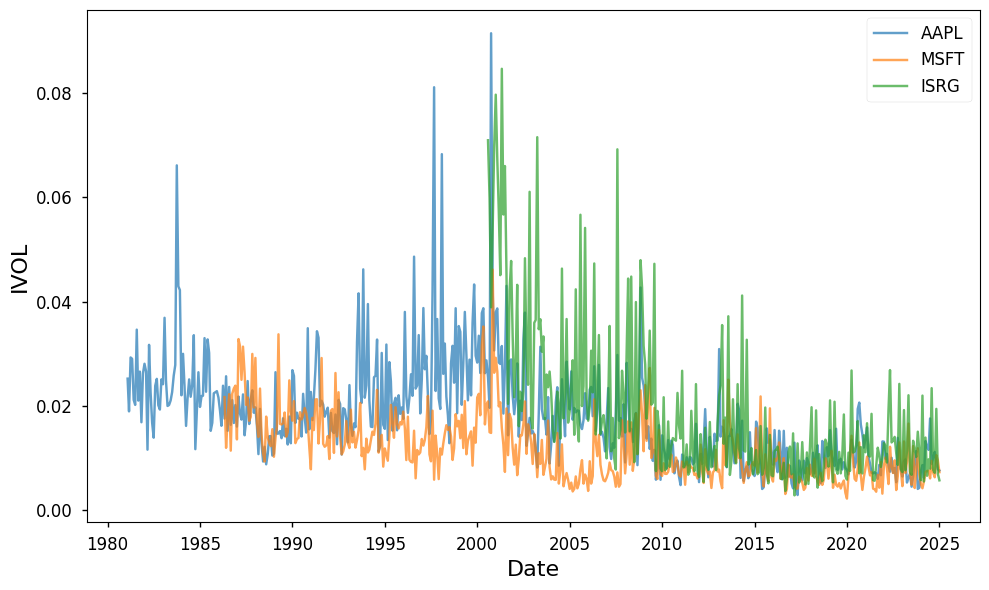

In [160]:
tickers = ['AAPL', 'MSFT', 'ISRG']
tickers_permno_map = conn.raw_sql(
    f"""
    SELECT DISTINCT permno, ticker
    FROM crsp.msenames
    WHERE ticker in ({','.join(["'" + t + "'" for t in tickers])})
    """
)
tickers_permno_map

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

for ticker in tickers:
    permno = tickers_permno_map[
        tickers_permno_map['ticker'] == ticker
    ]['permno'].iloc[0]
    ax.plot(
        ivol_df[str(permno)],
        label = ticker,
        alpha = .7
    )

ax.set_xlabel('Date')
ax.set_ylabel('IVOL')
ax.legend()

plt.tight_layout()
plt.show()

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_27883/1089430662.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


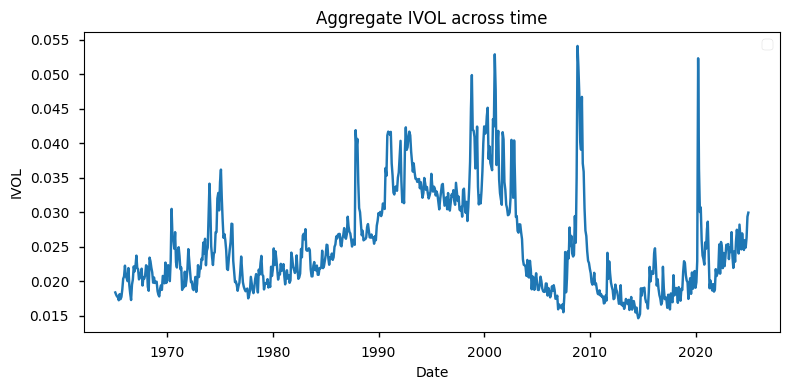

In [167]:
ivol_by_date = ivol_df.apply(lambda x: x.mean(), axis = 1)

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.plot(
    ivol_by_date
)
ax.set_xlabel('Date')
ax.set_ylabel('IVOL')
ax.legend()

ax.set_title("Aggregate IVOL across time")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, '10 randomly picked IVOLs')

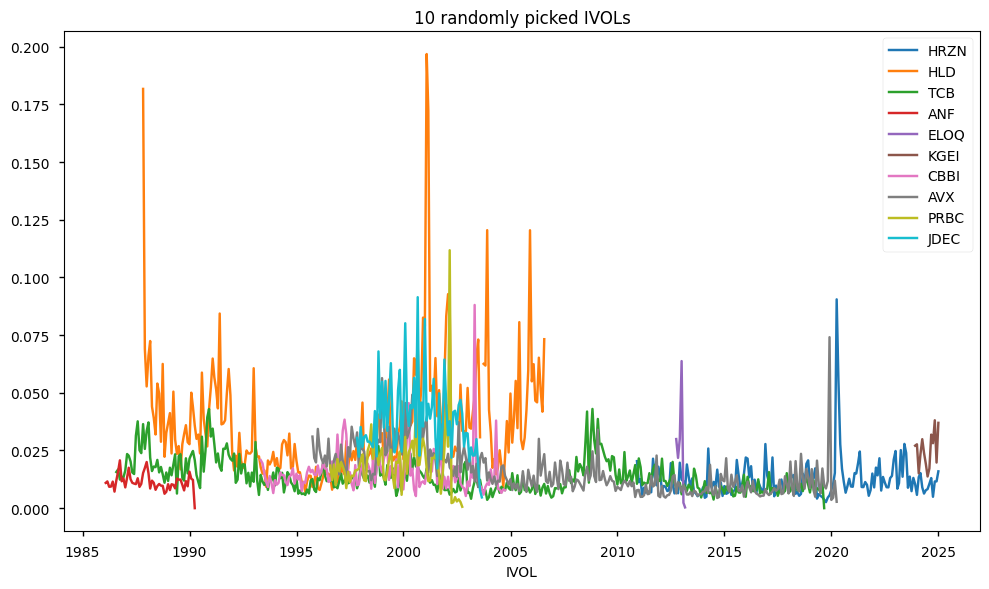

In [175]:
fig, ax = plt.subplots(1, 1)
for rng_col in np.random.randint(0, ivol_df.shape[1], size = 10):
    ticker = conn.raw_sql(
        f"""
            SELECT DISTINCT ticker
            FROM crsp.msenames
            WHERE permno = {ivol_df.columns[rng_col]}
        """
    )['ticker'][0]
    ax.plot(
        ivol_df.iloc[:, rng_col],
        label = ticker
    )
ax.set_xlabel('Date')
ax.set_xlabel('IVOL')
ax.legend()
ax.set_title("10 randomly picked IVOLs")

In [250]:
(ivol_df.columns.value_counts() > 1).sum()

0

## IVOL long-short strategy exploration

We consider a LS strategy where we long the 10% lowest IVOL stocks every month, and short the 10% highest IVOL stocks every month. If there is truly a negative IVOL effect on expected return, this strategy should generate excess returns. 

In [160]:
conn = wrds.Connection()
ivol_df = pd.read_csv(
    './full_ivol_df.csv', 
    index_col=0, 
)

ivol_df.index = pd.to_datetime(ivol_df.index)
ivol_df.columns = ivol_df.columns.astype(int)

Loading library list...
Done


In [187]:
conn = wrds.Connection()

Loading library list...
Done


In [191]:
quantile_low = 0.10
quantile_high = 0.90

long_short_dict = {}

for date, row in ivol_df.iterrows():
    print("======" * 10)
    ivol_today = row.dropna()

    prices = conn.raw_sql(
        f"""
        SELECT permno
        FROM crsp.msf
        WHERE date =  '{date.strftime("%Y-%m-%d")}'
        AND prc >= 5
        """
    ).set_index('permno')
    if prices.shape[0] == 0:
        prices = conn.raw_sql(
            f"""
                SELECT DISTINCT ON (permno) permno, prc, date
                FROM crsp.msf
                WHERE date <= '{date.strftime("%Y-%m-%d")}'
                ORDER BY permno, date DESC
            """
        )

        prices = prices[prices['prc']>=5].set_index("permno")

    ivol_filtered = ivol_today[ivol_today.index.isin(prices.index)]
    
    if len(ivol_filtered) < 10:
        print(f"Skipping {date},  not enough tradeable securities")
        continue

    low_thresh = ivol_filtered.quantile(quantile_low)
    high_thresh = ivol_filtered.quantile(quantile_high)
    print(f"low threshold: {low_thresh:.4f}, high threshold: {high_thresh:.4f}")

    long_stocks = ivol_filtered[ivol_filtered <= low_thresh].index.tolist()
    short_stocks = ivol_filtered[ivol_filtered >= high_thresh].index.tolist()

    print(
        f"long leg mean IVOL: {ivol_df.loc[date, long_stocks].mean():.4f}"
    )
    print(
        f"short leg mean IVOL: {ivol_df.loc[date, short_stocks].mean():.4f}"
    )

    print(f"Processed {date}, {len(ivol_filtered)} total, {len(long_stocks)} longs, {len(short_stocks)} shorts")

    long_short_dict[date] = {
        'long': long_stocks,
        'short': short_stocks
    }



ls_returns = []

for date, positions in long_short_dict.items():
    print(f"Processing {date}")
    next_month = (date + pd.offsets.MonthEnd(1)).strftime("%Y-%m-%d")

    tickers = positions['long'] + positions['short']

    ret_data = conn.raw_sql(
        f"""
        SELECT permno, ret
        FROM crsp.msf
        WHERE date = '{next_month}'
        """
    )

    long_returns = ret_data[ret_data['permno'].isin(positions['long'])]['ret']
    short_returns = ret_data[ret_data['permno'].isin(positions['short'])]['ret']

    if len(long_returns) == 0 or len(short_returns) == 0:
        continue

    # we work with equal-weighted portfolio for now
    long_ret = long_returns.mean()
    short_ret = short_returns.mean()

    ls_return = long_ret - short_ret

    ls_returns.append({
        'date': date,
        'long_ret': long_ret,
        'short_ret': short_ret,
        'ls_ret': ls_return
    })
    print(f"Processed {date}, LS return: {ls_return}")

ls_df = pd.DataFrame(ls_returns).set_index('date')

low threshold: 0.0067, high threshold: 0.0258
long leg mean IVOL: 0.0055
short leg mean IVOL: 0.0349
Processed 1965-01-31 00:00:00, 720 total, 148 longs, 148 shorts
low threshold: 0.0068, high threshold: 0.0267
long leg mean IVOL: 0.0057
short leg mean IVOL: 0.0352
Processed 1965-02-28 00:00:00, 720 total, 149 longs, 149 shorts
low threshold: 0.0064, high threshold: 0.0264
long leg mean IVOL: 0.0055
short leg mean IVOL: 0.0346
Processed 1965-03-31 00:00:00, 720 total, 147 longs, 147 shorts
low threshold: 0.0064, high threshold: 0.0263
long leg mean IVOL: 0.0053
short leg mean IVOL: 0.0345
Processed 1965-04-30 00:00:00, 720 total, 153 longs, 153 shorts
low threshold: 0.0065, high threshold: 0.0254
long leg mean IVOL: 0.0055
short leg mean IVOL: 0.0343
Processed 1965-05-31 00:00:00, 720 total, 149 longs, 149 shorts
low threshold: 0.0081, high threshold: 0.0244
long leg mean IVOL: 0.0068
short leg mean IVOL: 0.0314
Processed 1965-06-30 00:00:00, 720 total, 152 longs, 152 shorts
low thresh

In [197]:
ls_df = pd.DataFrame(ls_returns).set_index('date')

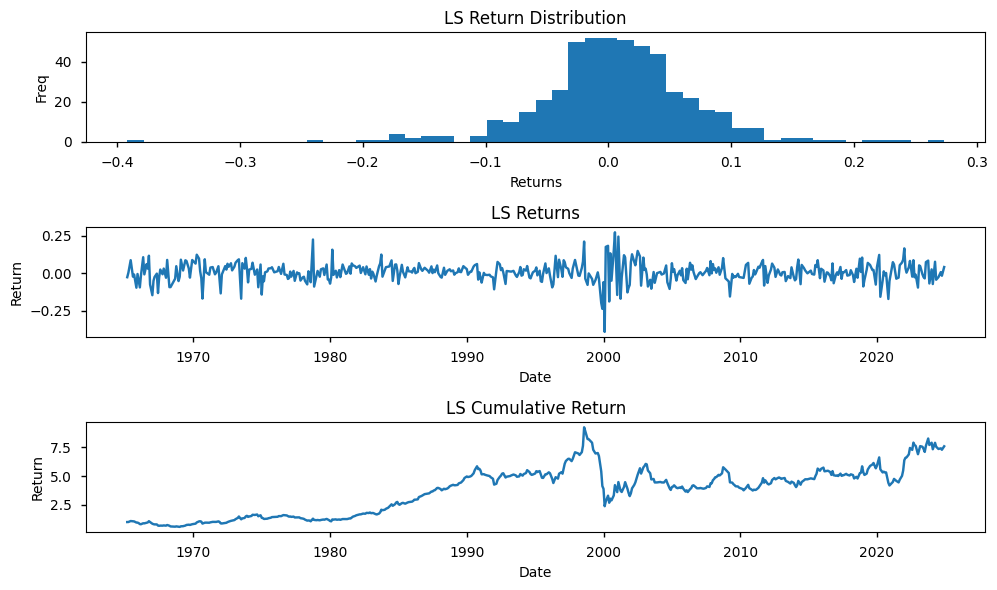

Text(0.5, 1.0, 'Cumulative Return')

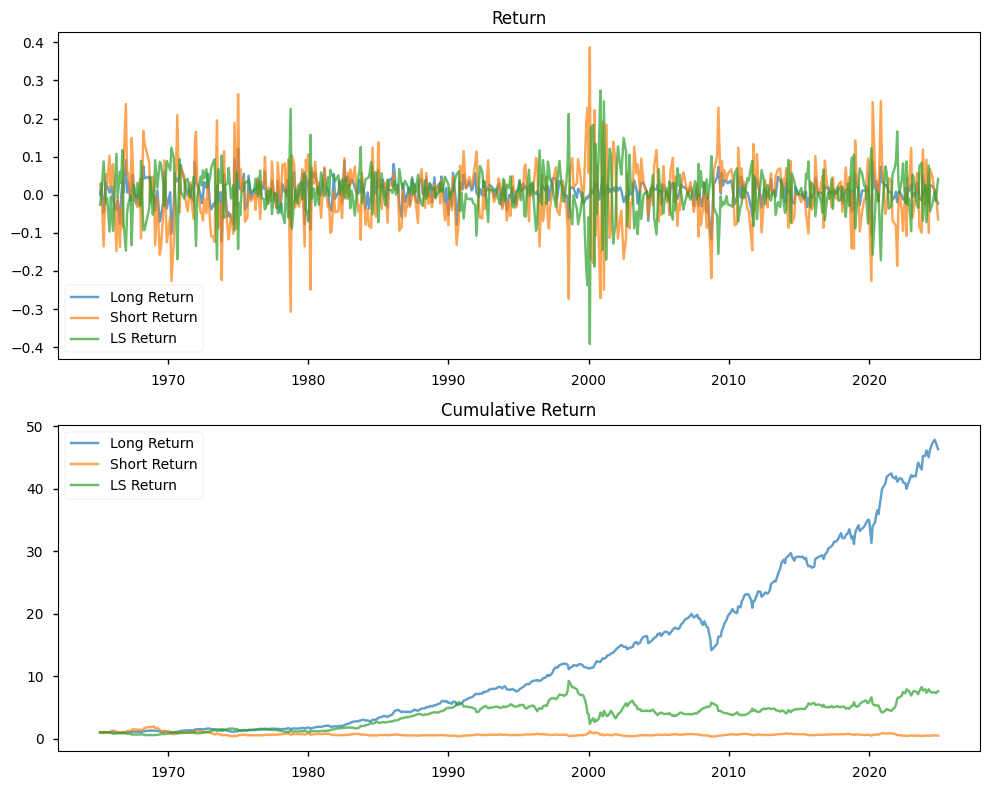

In [198]:
fig, axes = plt.subplots(3, 1, figsize= (10, 6))
axes[0].hist(
    ls_df['ls_ret'],
    bins = 50,
)

axes[0].set_xlabel("Returns")
axes[0].set_ylabel("Freq")

axes[1].plot(
    ls_df['ls_ret']
)

axes[1].set_xlabel("Date")
axes[1].set_ylabel("Return")
axes[1].set_title("LS Returns")

axes[2].plot(
    (ls_df['ls_ret'] + 1).cumprod()
)

axes[2].set_xlabel("Date")
axes[2].set_ylabel("Return")

axes[0].set_title("LS Return Distribution")
axes[2].set_title("LS Cumulative Return")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 1, figsize = (10, 8))

axes[0].plot(
    ls_df['long_ret'],
    label = "Long Return",
    alpha = .7
)

axes[0].plot(
    ls_df['short_ret'],
    label = "Short Return",
    alpha = .7
)

axes[0].plot(
    ls_df['ls_ret'],
    label = "LS Return",
    alpha = .7
)

axes[0].legend()

axes[0].set_title("Return")

axes[1].plot(
    (ls_df['long_ret'] + 1).cumprod(),
    label = "Long Return",
    alpha = .7
)

axes[1].plot(
    (ls_df['short_ret'] + 1).cumprod(),
    label = "Short Return",
    alpha = .7
)

axes[1].plot(
    (ls_df['ls_ret'] + 1).cumprod(),
    label = "LS Return",
    alpha = .7
)

axes[1].legend()
axes[1].set_title("Cumulative Return")


In [199]:
ls_df = ls_df.merge(
    factors,
    left_index = True,
    right_index = True
)

ls_df

,long_ret,short_ret,ls_ret,mktrf,smb,hml,rf
date,,,,,,,
1965-03-31,0.030668,0.027053,0.003615,0.0001,0.0019,0.0012,0.00016
1965-08-31,0.022647,0.031098,-0.008451,-0.0005,0.0029,-0.0006,0.00015
1965-11-30,0.012768,0.017782,-0.005014,-0.0015,0.0012,0.0019,0.00017
1965-12-31,0.021850,0.070867,-0.049017,0.0026,0.0006,0.0013,0.00015
1966-01-31,-0.014371,0.080214,-0.094585,-0.0045,0.0020,-0.0022,0.00018
...,...,...,...,...,...,...,...
2023-07-31,-0.010330,-0.084709,0.074379,0.0026,0.0108,-0.0008,0.00022
2023-10-31,0.050424,0.118725,-0.068301,0.0063,0.0005,-0.0007,0.00021
2024-01-31,0.019417,0.091573,-0.072157,-0.0174,-0.0091,-0.0031,0.00022


In [200]:
y = np.asarray(ls_df['ls_ret'] - ls_df['rf'])
X = np.asarray(
    ls_df[['mktrf', 'smb', 'hml']]
)
X = sm.add_constant(X)

res = sm.OLS(y, X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.644
Date:                Mon, 21 Apr 2025   Prob (F-statistic):              0.179
Time:                        00:37:17   Log-Likelihood:                 395.74
No. Observations:                 302   AIC:                            -783.5
Df Residuals:                     298   BIC:                            -768.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.004      0.384      0.701      -0.006       0.009
x1             0.7307      0.399      1.831      0.068      -0.055       1.516
x2             0.7158      0.634      1.129      0.260      -0.532       1.963
x3            -0.2500      0.731     -0.342      0.732      -1.688       1.188
==============================================================================
Omnibus:                       50.763   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              355.885
Skew:                          -0.408   Prob(JB):                     5.26e-78
Kurtosis:                       8.255   Cond. No.                         210.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Generating aggregate overpricing measure

In [ ]:
# synthetic data in the same schema

# this is for verifying that our function works
dates = pd.date_range(
    start = "1965-01-01",
    end = "2025-01-01",
    freq = "ME"
)

vars = ["var" + str(i) for i in range(1, 10)]

dates = pd.Series(dates)
vars = pd.Series(vars)


df = pd.MultiIndex.from_product(
    [dates, vars], 
    names=['dates', 'vars']
).to_frame(index=False)

df

,dates,vars
0,1965-01-31,var1
1,1965-01-31,var2
2,1965-01-31,var3
3,1965-01-31,var4
4,1965-01-31,var5
...,...,...
6475,2024-12-31,var5
6476,2024-12-31,var6
6477,2024-12-31,var7
6478,2024-12-31,var8


In [146]:
for i in range(1, 100):
    df["t"+str(i)] = np.random.randn(df.shape[0])

df

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_67248/3624248973.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["t"+str(i)] = np.random.randn(df.shape[0])


,dates,vars,t1,t2,t3,t4,t5,t6,t7,t8,...,t90,t91,t92,t93,t94,t95,t96,t97,t98,t99
0,1965-01-31,var1,-0.441807,-0.008487,-0.875036,2.144035,0.093414,0.091614,-0.504548,-2.365993,...,-0.091883,-0.516119,-1.615654,-1.469003,-1.226894,1.199113,0.164377,1.861170,-1.552188,1.132924
1,1965-01-31,var2,0.293290,-1.824104,1.272812,-1.368619,0.315598,-2.032665,1.014653,-0.887033,...,0.644053,1.079758,2.432239,0.474184,0.161141,-0.887368,-0.063588,1.078691,-2.130989,-2.192592
2,1965-01-31,var3,1.132755,-0.673239,-1.754806,-0.554960,0.734294,-0.833143,0.244272,-0.144377,...,-0.040104,-0.470947,0.331934,0.803510,0.976035,0.632291,-0.889573,-0.021974,0.884803,-1.319519
3,1965-01-31,var4,-1.101601,0.742374,0.671559,-0.974608,0.479644,-1.457233,-0.740339,0.318275,...,1.194202,0.285369,0.581830,-0.671451,0.993500,0.060946,-0.097125,0.813607,1.189692,0.121562
4,1965-01-31,var5,-0.032679,0.516943,1.063091,0.031862,-0.266274,0.965730,-1.826285,-1.676520,...,0.807938,-0.441710,0.677024,0.171548,-1.072365,-1.088226,-0.554183,-0.292678,0.202474,1.551670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,2024-12-31,var5,1.851302,0.904204,1.773893,-1.760095,0.875191,1.073836,2.105553,-1.239649,...,0.327393,0.168458,-0.135307,-0.600092,-0.639477,1.368503,-0.397358,0.306978,-1.601610,-0.413883
6476,2024-12-31,var6,-0.107486,-0.285636,-1.398043,-0.495753,1.603295,-0.513842,1.015903,-0.100123,...,-0.691716,0.188797,1.687894,-1.924614,0.114692,1.236597,1.742375,-0.537950,-0.645427,0.205290
6477,2024-12-31,var7,2.108345,-1.523098,0.334431,0.270262,1.612487,-1.151535,-0.209712,-0.102796,...,-0.482515,-0.925419,0.639806,0.004315,0.690142,0.150386,0.132576,-0.206147,0.131761,0.298690
6478,2024-12-31,var8,-0.262075,0.311173,-0.159970,0.154566,0.564937,0.178552,0.750722,-0.407969,...,-0.538750,0.828655,2.445054,0.575953,-0.497085,0.160118,-1.127320,-1.125147,0.979077,0.478410


In [209]:
# this is the function we would use to aggregate percentile rankings
df.groupby('dates')[
    [c for c in df.columns if c not in ["dates", "vars"]]
].apply(lambda x: x.dropna().mean())

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t90,t91,t92,t93,t94,t95,t96,t97,t98,t99
dates,,,,,,,,,,,,,,,,,,,,,
1965-01-31,-0.006828,-0.152150,0.068256,-0.251568,0.035473,-0.165474,-0.602547,-0.382576,0.305956,-0.796672,...,0.400804,-0.056424,0.343052,-0.522366,0.363880,-0.169733,-0.306409,0.202198,-0.097073,-0.127820
1965-02-28,-0.091431,-0.196523,0.003984,0.371143,-0.334206,-0.418829,0.049380,-0.150677,-0.159633,0.534664,...,0.181853,0.139791,0.793225,-0.161031,-0.248494,0.021767,0.212117,0.236888,-0.146114,0.027131
1965-03-31,-0.425332,0.024079,-0.528917,-0.024422,-0.332498,-0.792533,0.417152,0.186438,-0.200491,0.142415,...,0.296794,0.291585,0.057799,-0.244256,-0.135906,0.295233,0.376003,0.397100,-0.149409,0.007766
1965-04-30,-0.015920,-0.115124,-0.109150,-0.126310,-0.100391,0.173788,0.133577,0.150689,0.284836,-0.017701,...,0.731353,-0.364319,0.140337,0.012470,-0.136392,-0.354775,-0.052718,0.760516,-0.270601,-0.588306
1965-05-31,0.088386,0.265664,-0.188942,0.050428,-0.347836,0.354603,-0.177878,0.087315,-0.596069,0.516581,...,-0.152551,0.719689,-0.669757,0.148858,-0.101833,0.225151,0.087676,0.466723,-0.004757,-0.686520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.372884,-0.294767,-0.067787,-0.718680,-0.375511,0.226677,0.092886,-0.045459,-0.264398,0.138568,...,0.319838,0.871770,-0.036350,-0.040783,0.399076,0.077320,0.110709,0.113211,-0.007767,-0.059094
2024-09-30,0.179484,0.090719,-0.319380,-0.314840,-0.511353,0.280660,0.085964,0.188626,-0.456166,0.599935,...,-0.530081,0.447768,0.048590,-0.016070,0.387484,-0.069082,-0.402155,-0.221663,0.198079,0.210136
2024-10-31,-0.364925,0.292952,-0.007274,0.478747,0.264273,-0.296188,0.245920,-0.347114,0.133817,-0.086381,...,-0.090269,0.493185,0.407583,-0.068462,-0.416101,0.162726,-0.054570,0.048914,-0.286377,-0.491059


In [2]:
anomalies_df = pd.read_csv('anomalies_raw_new.csv')
anomalies_df

,date,variable,10003,10007,10010,10016,10017,10021,10027,10031,...,93371,93374,93384,93390,93392,93395,93397,93427,93428,93435
0,1965-01-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1965-02-28,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1965-03-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1965-04-30,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1965-05-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,2024-08-31,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.125307,0.018117,NaN,NaN,NaN,NaN,0.453436,0.371898,NaN,NaN
8636,2024-09-30,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.686486,0.159861,NaN,NaN,NaN,NaN,0.663626,0.462309,NaN,NaN
8637,2024-10-31,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.321839,0.328630,NaN,NaN,NaN,NaN,0.874680,0.525419,NaN,NaN
8638,2024-11-30,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.093846,0.114412,NaN,NaN,NaN,NaN,0.710237,0.488388,NaN,NaN


In [3]:
anomalies_df.set_index(['date', 'variable'], inplace=True)
anomalies_df

,,10003,10007,10010,10016,10017,10021,10027,10031,10035,10042,...,93371,93374,93384,93390,93392,93395,93397,93427,93428,93435
date,variable,,,,,,,,,,,,,,,,,,,,,
1965-01-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.125307,0.018117,NaN,NaN,NaN,NaN,0.453436,0.371898,NaN,NaN
2024-09-30,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.686486,0.159861,NaN,NaN,NaN,NaN,0.663626,0.462309,NaN,NaN
2024-10-31,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.321839,0.328630,NaN,NaN,NaN,NaN,0.874680,0.525419,NaN,NaN


In [222]:
# we want to find missing columns

missing_cols = ivol_df.columns[
    (~ivol_df.columns.isin(anomalies_df.columns.astype(int)))
]

(array([309., 281., 311., 302., 307., 322., 311., 286., 304., 313.]),
 array([2.00000e+00, 3.37090e+03, 6.73980e+03, 1.01087e+04, 1.34776e+04,
        1.68465e+04, 2.02154e+04, 2.35843e+04, 2.69532e+04, 3.03221e+04,
        3.36910e+04]),
 <BarContainer object of 10 artists>)

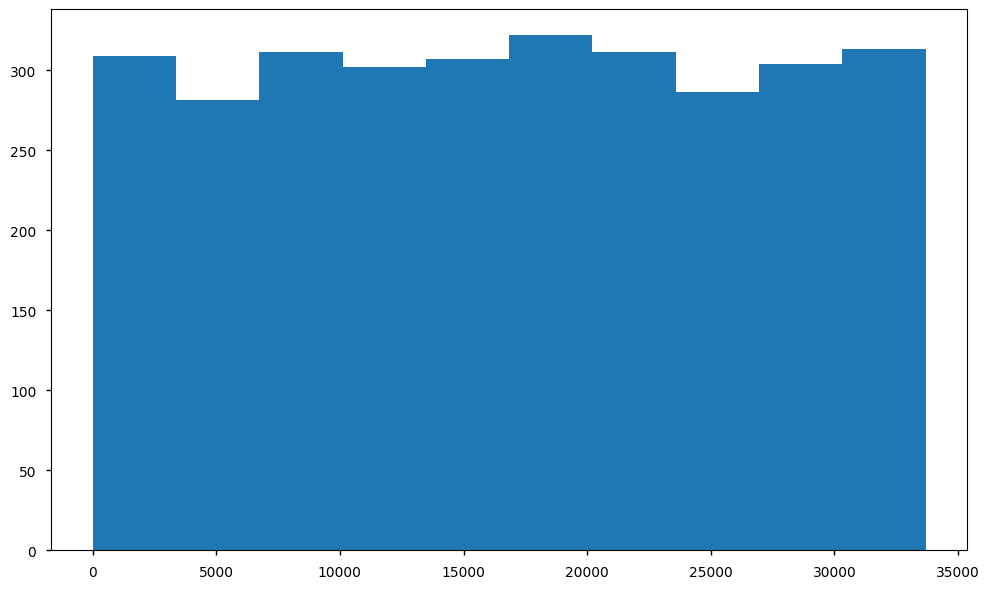

In [225]:
missing_col_indices = np.arange(ivol_df.shape[1])[
    ivol_df.columns.isin(missing_cols)
]

plt.hist(missing_col_indices)

In [229]:
test_permno = missing_cols[0]
test_permno

10896

In [237]:
start = '1965-01-01'
end = '2025-01-01'
prc_history = conn.raw_sql(
    f"""
        SELECT date, prc 
        FROM crsp.msf
        WHERE permno = {test_permno}
        AND date between '{start}' AND '{end}'
        AND prc >= 5
    """,
    date_cols=date
)

prc_history


,date,prc


In [241]:
missing_column_logs = {}
for i, permno in enumerate(missing_cols):
    prc_history = conn.raw_sql(
        f"""
            SELECT date, prc 
            FROM crsp.msf
            WHERE permno = {test_permno}
            AND date between '{start}' AND '{end}'
            AND prc >= 5
        """,
        date_cols=date
    )
    missing_column_logs[permno] = prc_history
    if prc_history.shape[0] > 0:
        print(f"ERROR: {prc_history.shape[0]} positive prices found for permno: {permno}")
    else:
        print(f"Checking {i}/{len(missing_cols)}, {permno}, ok")



Checking 0/3046, 10896, ok
Checking 1/3046, 52784, ok
Checking 2/3046, 85957, ok
Checking 3/3046, 12251, ok
Checking 4/3046, 11158, ok
Checking 5/3046, 80246, ok
Checking 6/3046, 32628, ok
Checking 7/3046, 34607, ok
Checking 8/3046, 45859, ok
Checking 9/3046, 31019, ok
Checking 10/3046, 31086, ok
Checking 11/3046, 90150, ok
Checking 12/3046, 79690, ok
Checking 13/3046, 78294, ok
Checking 14/3046, 71897, ok
Checking 15/3046, 78420, ok
Checking 16/3046, 45082, ok
Checking 17/3046, 11152, ok
Checking 18/3046, 83476, ok
Checking 19/3046, 60207, ok
Checking 20/3046, 23636, ok
Checking 21/3046, 57031, ok
Checking 22/3046, 92037, ok
Checking 23/3046, 18894, ok
Checking 24/3046, 75644, ok
Checking 25/3046, 24093, ok
Checking 26/3046, 25639, ok
Checking 27/3046, 21831, ok
Checking 28/3046, 76778, ok
Checking 29/3046, 11126, ok
Checking 30/3046, 52266, ok
Checking 31/3046, 60653, ok
Checking 32/3046, 88621, ok
Checking 33/3046, 37372, ok
Checking 34/3046, 73868, ok
Checking 35/3046, 53592, ok
Ch

In [242]:
for k, v in missing_column_logs.items():
    if v.shape[0] > 0:
        print(f"Error, {k}")

In [250]:
anomalies_df.loc[
    ('1965-01-31', 'at_gr1'), 
].dropna()

10102    0.103067
10161    0.268391
10233    0.048295
10372   -0.013914
10487    0.104933
           ...   
40977    0.785714
41072    0.220657
41187    0.076162
41486    0.203188
53023   -0.090372
Name: (1965-01-31, at_gr1), Length: 1080, dtype: float64

In [251]:
anomalies_df.loc[
    ('1965-01-31', 'at_gr1'), 
].rank(pct=True).dropna()

10102    0.686111
10161    0.904630
10233    0.440741
10372    0.112037
10487    0.696296
           ...   
40977    0.991667
41072    0.879630
41187    0.593519
41486    0.862037
53023    0.020370
Name: (1965-01-31, at_gr1), Length: 1080, dtype: float64

In [4]:
anomalies_pct = pd.DataFrame(
    index = anomalies_df.index,
    columns = anomalies_df.columns
)
anomalies_pct

,,10003,10007,10010,10016,10017,10021,10027,10031,10035,10042,...,93371,93374,93384,93390,93392,93395,93397,93427,93428,93435
date,variable,,,,,,,,,,,,,,,,,,,,,
1965-01-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
for i, idx in enumerate(anomalies_pct.index):
    print(f"Processing {i} out of {anomalies_pct.shape[0]}")
    anomalies_pct.loc[idx] = anomalies_df.loc[idx].rank(pct=True)


Processing 0 out of 8640
Processing 1 out of 8640
Processing 2 out of 8640
Processing 3 out of 8640
Processing 4 out of 8640
Processing 5 out of 8640
Processing 6 out of 8640
Processing 7 out of 8640
Processing 8 out of 8640
Processing 9 out of 8640
Processing 10 out of 8640
Processing 11 out of 8640
Processing 12 out of 8640
Processing 13 out of 8640
Processing 14 out of 8640
Processing 15 out of 8640
Processing 16 out of 8640
Processing 17 out of 8640
Processing 18 out of 8640
Processing 19 out of 8640
Processing 20 out of 8640
Processing 21 out of 8640
Processing 22 out of 8640
Processing 23 out of 8640
Processing 24 out of 8640
Processing 25 out of 8640
Processing 26 out of 8640
Processing 27 out of 8640
Processing 28 out of 8640
Processing 29 out of 8640
Processing 30 out of 8640
Processing 31 out of 8640
Processing 32 out of 8640
Processing 33 out of 8640
Processing 34 out of 8640
Processing 35 out of 8640
Processing 36 out of 8640
Processing 37 out of 8640
Processing 38 out of 8

In [6]:
aggregate_mispricing_df = anomalies_pct.reset_index().groupby('date')[
    [c for c in anomalies_pct.columns if c not in ['date', 'variable']]
].apply(lambda x: x.dropna().mean())

aggregate_mispricing_df

,10003,10007,10010,10016,10017,10021,10027,10031,10035,10042,...,93371,93374,93384,93390,93392,93395,93397,93427,93428,93435
date,,,,,,,,,,,,,,,,,,,,,
1965-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
aggregate_mispricing_df

## Splitting into 25 portfolios

In [ ]:
ivol_df

,83264,63618,10896,69906,79030,11233,44127,86580,91786,88837,...,56120,31713,85792,83586,89403,81454,79163,86036,92970,19812
1965-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.011945,NaN,NaN,NaN,NaN,NaN,NaN,0.025849,0.009253,0.013778,...,NaN,NaN,0.015452,NaN,0.018388,NaN,NaN,NaN,NaN,0.042034
2024-09-30,0.010587,NaN,NaN,NaN,NaN,NaN,NaN,0.011175,0.011429,0.010877,...,NaN,NaN,0.012494,NaN,0.010137,NaN,NaN,NaN,NaN,0.162169
2024-10-31,0.007728,NaN,NaN,NaN,NaN,NaN,NaN,0.016819,0.010310,0.047612,...,NaN,NaN,0.008540,NaN,0.009744,NaN,NaN,NaN,NaN,0.045123
2024-11-30,0.008987,NaN,NaN,NaN,NaN,NaN,NaN,0.017378,0.012528,0.048934,...,NaN,NaN,0.010319,NaN,0.024362,NaN,NaN,NaN,NaN,0.108532


In [206]:
def map_quantile_fast(x, quantiles):
    if x <= quantiles[0]:
        return 0
    elif x <= quantiles[1]:
        return 1
    elif x <= quantiles[2]:
        return 2
    elif x <= quantiles[3]:
        return 3
    else:
        return 4

ivol_quintiles = pd.DataFrame(index=ivol_df.index, columns=ivol_df.columns)

for idx in ivol_df.index:
    permnos = conn.raw_sql(
        f"""
        SELECT permno
        FROM crsp.msf
        WHERE date = '{idx.strftime("%Y-%m-%d")}'
        AND prc >= 5
        """
    )

    if permnos.shape[0] == 0:
        permnos = conn.raw_sql(
            f"""
            SELECT DISTINCT ON (permno) permno, prc, date
            FROM crsp.msf
            WHERE date <= '{idx.strftime("%Y-%m-%d")}'
            ORDER BY permno, date DESC
            """
        )
        permnos = permnos[permnos['prc'].abs() >= 5]

    valid_permnos = ivol_df.columns[ivol_df.columns.isin(permnos['permno'])]

    print(f"Processing {idx} - {len(valid_permnos)} permnos ranked")

    ivol_today = ivol_df.loc[idx, valid_permnos].dropna()
    quantiles = np.quantile(ivol_today, [0.2, 0.4, 0.6, 0.8])
    ranked = ivol_today.apply(lambda x: map_quantile_fast(x, quantiles))
    ivol_quintiles.loc[idx, ranked.index] = ranked

ivol_quintiles = ivol_quintiles.astype("Int64")

Processing 1965-01-31 00:00:00 - 1581 permnos ranked
Processing 1965-02-28 00:00:00 - 1606 permnos ranked
Processing 1965-03-31 00:00:00 - 1485 permnos ranked
Processing 1965-04-30 00:00:00 - 1547 permnos ranked
Processing 1965-05-31 00:00:00 - 1635 permnos ranked
Processing 1965-06-30 00:00:00 - 1539 permnos ranked
Processing 1965-07-31 00:00:00 - 1636 permnos ranked
Processing 1965-08-31 00:00:00 - 1531 permnos ranked
Processing 1965-09-30 00:00:00 - 1545 permnos ranked
Processing 1965-10-31 00:00:00 - 1685 permnos ranked
Processing 1965-11-30 00:00:00 - 1621 permnos ranked
Processing 1965-12-31 00:00:00 - 1661 permnos ranked
Processing 1966-01-31 00:00:00 - 1672 permnos ranked
Processing 1966-02-28 00:00:00 - 1714 permnos ranked
Processing 1966-03-31 00:00:00 - 1665 permnos ranked
Processing 1966-04-30 00:00:00 - 1776 permnos ranked
Processing 1966-05-31 00:00:00 - 1646 permnos ranked
Processing 1966-06-30 00:00:00 - 1646 permnos ranked
Processing 1966-07-31 00:00:00 - 1783 permnos 

In [207]:
ivol_quintiles.to_csv("ivol_quintiles.csv")

In [ ]:
ivol_quintiles